# GDELT dataset extraction

This notebook serves as the starting point for pulling the GDELT datasets over the *english* language. Multi-lingual datasets are also [available](https://blog.gdeltproject.org/a-new-multilingual-dataset-for-exploring-climate-change-narratives-4-1-million-news-urls-in-63-languages-2015-2020/), including 4.1M articles covering the global narrative. An interesting side project would be to perform weighted clustering and analyze how different the arguments are across different languages. This would require mapping clusters across languages, which is non-trivial but possibly doable.


Full datasets found [here](https://blog.gdeltproject.org/a-new-contextual-dataset-for-exploring-climate-change-narratives-6-3m-english-news-urls-with-contextual-snippets-2015-2020/)


In [1]:
import os
from pathlib import Path
import requests
import zipfile

import pandas as pd

In [2]:
# identify project root
notebook_dir = os.getcwd()
project_root = Path(notebook_dir).resolve().parents[1]

In [3]:
base_uri_fmt = "http://data.gdeltproject.org/blog/2020-climate-change-narrative/WebNewsEnglishSnippets.{year}.csv.zip"
years = list(range(2015, 2021))

In [6]:
year = 2020

In [7]:
GDELT_COL_NAMES = [
    "datetime",
    "title",
    "headline_image_url",
    "content_url",
    "snippit"
]

In [8]:
def download_file_from_url(url, target_file_path):
    """Download a file from the given url"""
    print("downloading file from {}".format(url))
    response = requests.get(url, allow_redirects=True)
    response.raise_for_status()
    with open(target_file_path, 'wb') as f:
        f.write(response.content)
    return
    
    

In [9]:
def get_gdelt_year(year):
    """
    Download the CSV files from the gdelt project, for a given year
    """
    full_url = base_uri_fmt.format(year=year)
    uri_path, zip_filename = os.path.split(full_url.split("://")[1]) 
    gdelt_project_name = os.path.basename(uri_path)
    gdelt_raw_dir = os.path.join(project_root, "data", "raw", gdelt_project_name)
    os.makedirs(gdelt_raw_dir, exist_ok=True)


    zip_filepath = os.path.join(gdelt_raw_dir, zip_filename)
    csv_filename, ext = os.path.splitext(zip_filename)
    if ext != ".zip":
        raise IOError("Expected to find a zip file, found '{}' instead".format(ext))
    csv_filepath = os.path.join(gdelt_raw_dir, csv_filename)

    if not os.path.isfile(csv_filepath):
        download_file_from_url(full_url, zip_filepath)
        with zipfile.ZipFile(zip_filepath, "r") as zip_ref:
            zip_ref.extractall(gdelt_raw_dir)
        # delete the zip file when we are done with it
        if os.path.exists(zip_filepath):
            os.remove(zip_filepath)
        else:
            print("Unable to find the zip file we just extracted from: {}".format(zip_filepath))
    else:
        print("Using cached data for '{}': {}".format(year, csv_filepath))
    df = pd.read_csv(csv_filepath, header=0, names=GDELT_COL_NAMES, index_col=False)
    return df

In [10]:
df = get_gdelt_year(year)

Using cached data for '2020': /opt/workspace/data/raw/2020-climate-change-narrative/WebNewsEnglishSnippets.2020.csv


In [11]:
df.head()

,datetime,title,headline_image_url,content_url,snippit
0,20200115111500,Liberal MPs back Science Minister Karen Andrew...,https://static.ffx.io/images/$zoom_0.2627%2C$m...,https://www.smh.com.au/politics/federal/libera...,the science in her interview with The Age and...
1,20200117184500,Several crowd-pullers on day two of KLF,https://www.thehindu.com/news/cities/kozhikode...,https://www.thehindu.com/news/cities/kozhikode...,"Guha, who talked about patriotism and jingois..."
2,20200106233000,Seven arrested after gas rig protest,https://www.stourbridgenews.co.uk/resources/im...,https://www.stourbridgenews.co.uk/news/nationa...,three demands for the Scottish and UK Governm...
3,20200101111500,Australia sending aid to wildfire towns as dea...,https://bloximages.newyork1.vip.townnews.com/h...,https://www.heraldmailmedia.com/news/nation/au...,this season the worst on record and reignited ...
4,20200107101500,"A hot, dry country caught between fire and a c...",NaN,http://global.chinadaily.com.cn/a/202001/07/WS...,", which is burned to generate electricity, wit..."


In [12]:
df.iloc[0][3]

'https://www.smh.com.au/politics/federal/liberals-speak-out-to-back-science-minister-on-climate-change-action-20200115-p53rs1.html'

In [14]:
def convert_datetime_int(datetime_int):
    """Convert an integer like 20200107101500 to a pd.Timestamp 2020.01.07T10:15:00"""
    # NOTE we still need to confirm that these times are all GMT
    datetime_str = str(datetime_int)
    if len(datetime_str) != 14:
        raise ValueError("Incorrect length for datetime integer, expected 12, found {}". format(len(datetime_str)))
    ts = pd.Timestamp(
        year=int(datetime_str[:4]),
        month=int(datetime_str[4:6]),
        day=int(datetime_str[6:8]),
        hour=int(datetime_str[8:10]),
        minute=int(datetime_str[10:12]),
        second=int(datetime_str[12:14]),
    )
    return ts

In [15]:
df['timestamp'] = df.datetime.apply(convert_datetime_int)

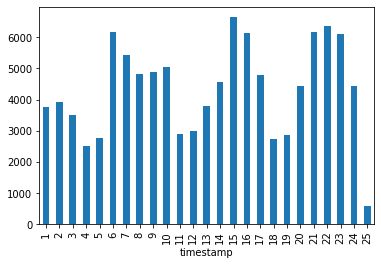

In [16]:
# plot the distribution by day of month
df.timestamp.groupby([df["timestamp"].dt.day]).count().plot(kind="bar")